In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
# %%cmd

# pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org pip kaleido

# pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org pip orca

# 0. Data and Packages

#### References
- [How to Select a Model For Your Time Series Prediction Task](https://neptune.ai/blog/select-model-for-time-series-prediction-task)  
- [Visualizing Data with Pairs Plots in Python](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import plotly
import kaleido
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


print(plotly.__version__)
print(kaleido.__version__)

from datetime import date
import glob


# customized modules
from src.data_prepare.data_loader import load_data

5.6.0
0.2.1


In [4]:
## Load original dataframe

## Load original dataframe

file_names = sorted(glob.glob("analyze-dataset/merged_data_*.csv"))

original_filename = file_names[-1]

_, _, df = load_data(original_filename, insample_end_year=2017)

print("insample: ", df.shape)

insample:  (118, 25)


# 1. First Glance

In [5]:
def plot_univariate_scatter(df, x_name, y_name, figsize=None):
    plt.figure(figsize=figsize)
    plt.scatter(x_name, y_name, data=df, marker="x")
    plt.title(f"{y_name} vs. {x_name}")
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()


def plot_univariate_line(df, x_name, y_name):
    fig = px.line(x=df[x_name], y=df[y_name], title=f"{y_name} vs. {x_name}")
    fig.show()

## 1.1 univariate distribution (Boxplot)   

- [Plot subplots different size](https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots)

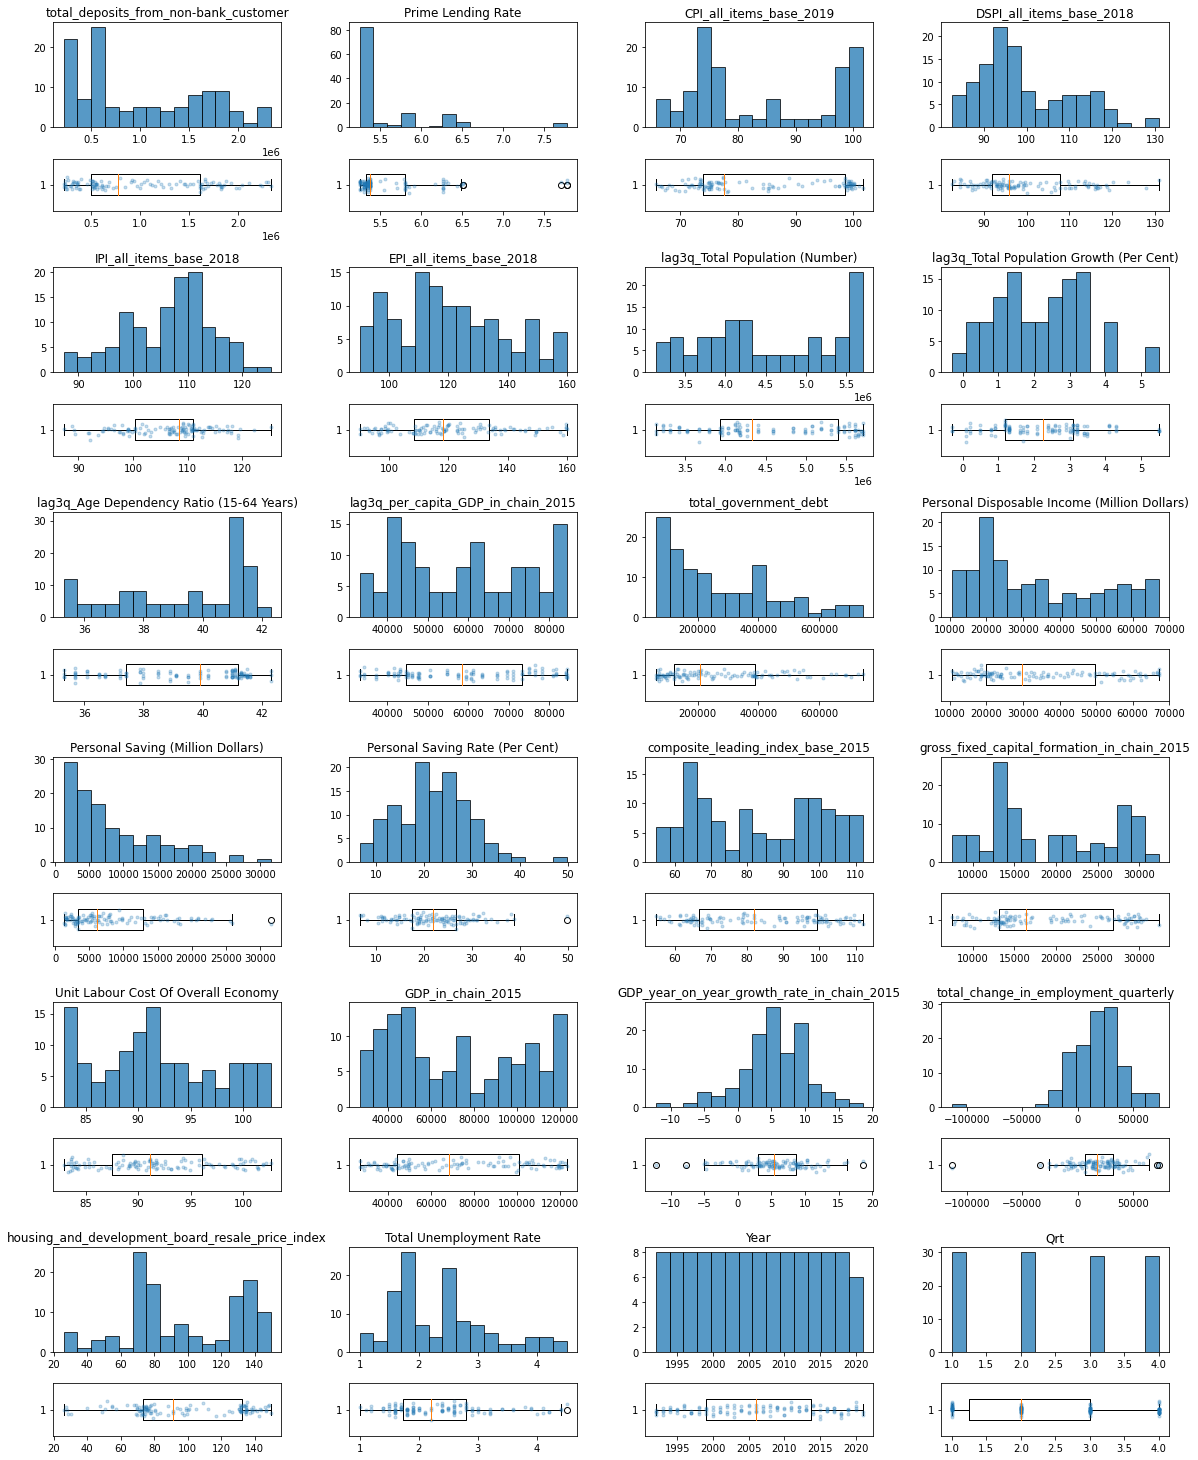

In [13]:
x_names = list(df.columns[1:])

fig = plt.figure(figsize=(20, 26))

row_num, col_num = 6, 4
outer = gridspec.GridSpec(row_num, col_num, wspace=0.3, hspace=0.3)

for i in range(row_num * col_num):
    inner = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=outer[i], wspace=0.4, hspace=0.4, height_ratios=[2, 1]
    )

    x_col = x_names[i]

    ## Histgram
    ax1 = plt.Subplot(fig, inner[0])
    ax1.set_title(x_col)
    ax1.hist(df[x_col], edgecolor="black", bins=15, alpha=0.75)
    fig.add_subplot(ax1)

    ## Boxplot
    ax2 = plt.Subplot(fig, inner[1])
    ax2.boxplot(df[x_col], vert=False, widths=0.4)
    # jittering
    x = np.random.normal(1, 0.06, size=len(df[x_col]))
    ax2.plot(df[x_col], x, ".", alpha=0.25)
    fig.add_subplot(ax2)

plt.savefig("./output/figures/univariate_distribution.png")
plt.show()

## 1.2 line plot

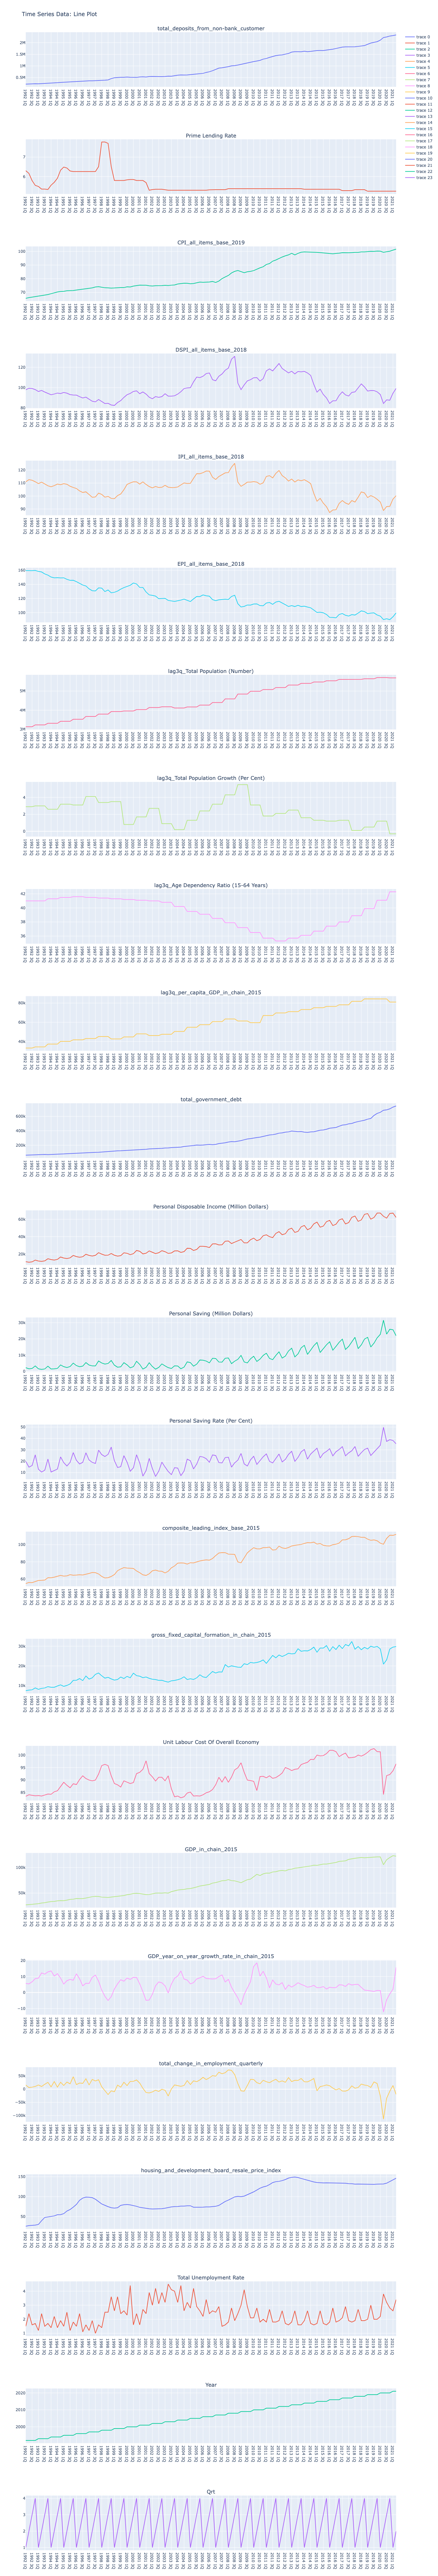

In [15]:
## line plot

time_col_name = "Data Series"

x_cols = list(df.columns)[1:]

fig = make_subplots(rows=len(x_cols), cols=1, subplot_titles=x_cols)

for i, col_name in enumerate(x_cols):
    fig.add_trace(go.Scatter(x=df["Data Series"], y=df[col_name]), row=i + 1, col=1)

fig.update_layout(height=8000, width=800, title_text="Time Series Data: Line Plot")


fig.write_image("./output/figures/line_plot.png")
fig.show()

# 2. Univariate Analysis

## 2.1 Pearson Correlation Coefficient  

Correlation in python:  
- The Pearson correlation is implemented in multiple packages including Numpy, Scipy, and Pandas. 
- If you have null or missing values in your data, correlation function in Pandas will drop those rows before computing whereas you need to manually remove those data if using Numpy or Scipy’s implementations.

In [16]:
def get_pearson_corr(df, col_1, col_2):
    res = stats.pearsonr(df[col_1], df[col_2])
    return res


def plot_corr_heatmap(df, method="pearson"):
    """
    Credit: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    
    
    """
    # Compute the correlation matrix
    corr = df.corr(method=method)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=0.3,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        annot=True,
        annot_kws={"fontsize": 7},
    )

    plt.savefig("./output/figures/heatmap.png")

    return corr

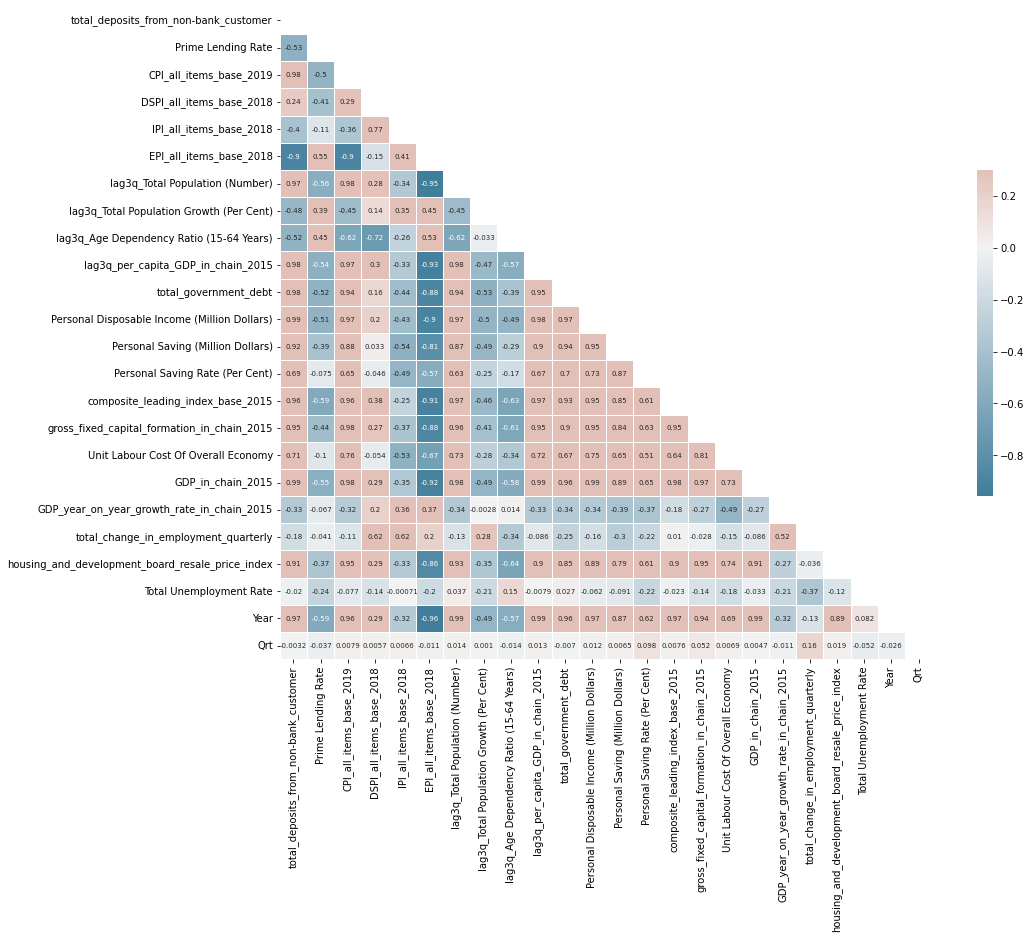

In [17]:
temp_df = df.iloc[:, 1:]

# print(temp_df.dtypes)
# display(temp_df)

temp_df = temp_df.astype("float64")

corr = plot_corr_heatmap(temp_df)

corr.to_csv("./output/texts/corr_heatmap_all_variables.csv")

## 2.2 Dependent variable

- credit: https://realpython.com/numpy-scipy-pandas-correlation-python/#example-pandas-correlation-calculation  


Data Series  total_deposits_from_non-bank_customer  Prime Lending Rate  \
0     1992 1Q                               218934.1            6.303333   
1     1992 2Q                               226763.1            6.163333   
2     1992 3Q                               232916.5            5.793333   
3     1992 4Q                               234922.8            5.550000   
4     1993 1Q                               233819.7            5.493333   

   CPI_all_items_base_2019  DSPI_all_items_base_2018  IPI_all_items_base_2018  \
0                65.710000                    97.909               110.981333   
1                66.245667                    99.444               112.640667   
2                66.586333                    99.163               112.171667   
3                66.886667                    98.097               110.981667   
4                67.344000                    96.250               109.576000   

   EPI_all_items_base_2018  lag3q_Total Population (Number)  \
0               159.644000                        3135083.0   
1               159.595667                        3135083.0   
2               159.448667                        3135083.0   
3               159.791667                        3230698.0   
4               158.419000                        3230698.0   

   lag3q_Total Population Growth (Per Cent)  \
0                                       2.9   
1                                       2.9   
2                                       2.9   
3                                       3.0   
4                                       3.0   

   lag3q_Age Dependency Ratio (15-64 Years)  ...  \
0                                      41.0  ...   
1                                      41.0  ...   
2                                      41.0  ...   
3                                      41.0  ...   
4                                      41.0  ...   

   composite_leading_index_base_2015  \
0                               54.7   
1                               56.0   
2                               55.8   
3                               57.0   
4                               58.3   

   gross_fixed_capital_formation_in_chain_2015  \
0                                       7462.0   
1                                       7759.5   
2                                       7897.1   
3                                       8875.4   
4                                       8142.5   

   Unit Labour Cost Of Overall Economy  GDP_in_chain_2015  \
0                                 83.5            26919.1   
1                                 84.1            27242.4   
2                                 83.9            27973.8   
3                                 83.7            28725.1   
4                                 83.8            29362.8   

   GDP_year_on_year_growth_rate_in_chain_2015  \
0                                         5.7   
1                                         5.4   
2                                         6.7   
3                                         8.7   
4                                         9.0   

   total_change_in_employment_quarterly  \
0                               15900.0   
1                                6200.0   
2                                7700.0   
3                               10500.0   
4                               15900.0   

   housing_and_development_board_resale_price_index  Total Unemployment Rate  \
0                                              25.8                      1.5   
1                                              27.4                      2.4   
2                                              28.0                      1.6   
3                                              28.6                      1.7   
4                                              30.2                      1.2   

   Year  Qrt  
0  1992    1  
1  1992    2  
2  1992    3  
3  1992    4  
4  1993    1  

[5 rows x 25 columns]

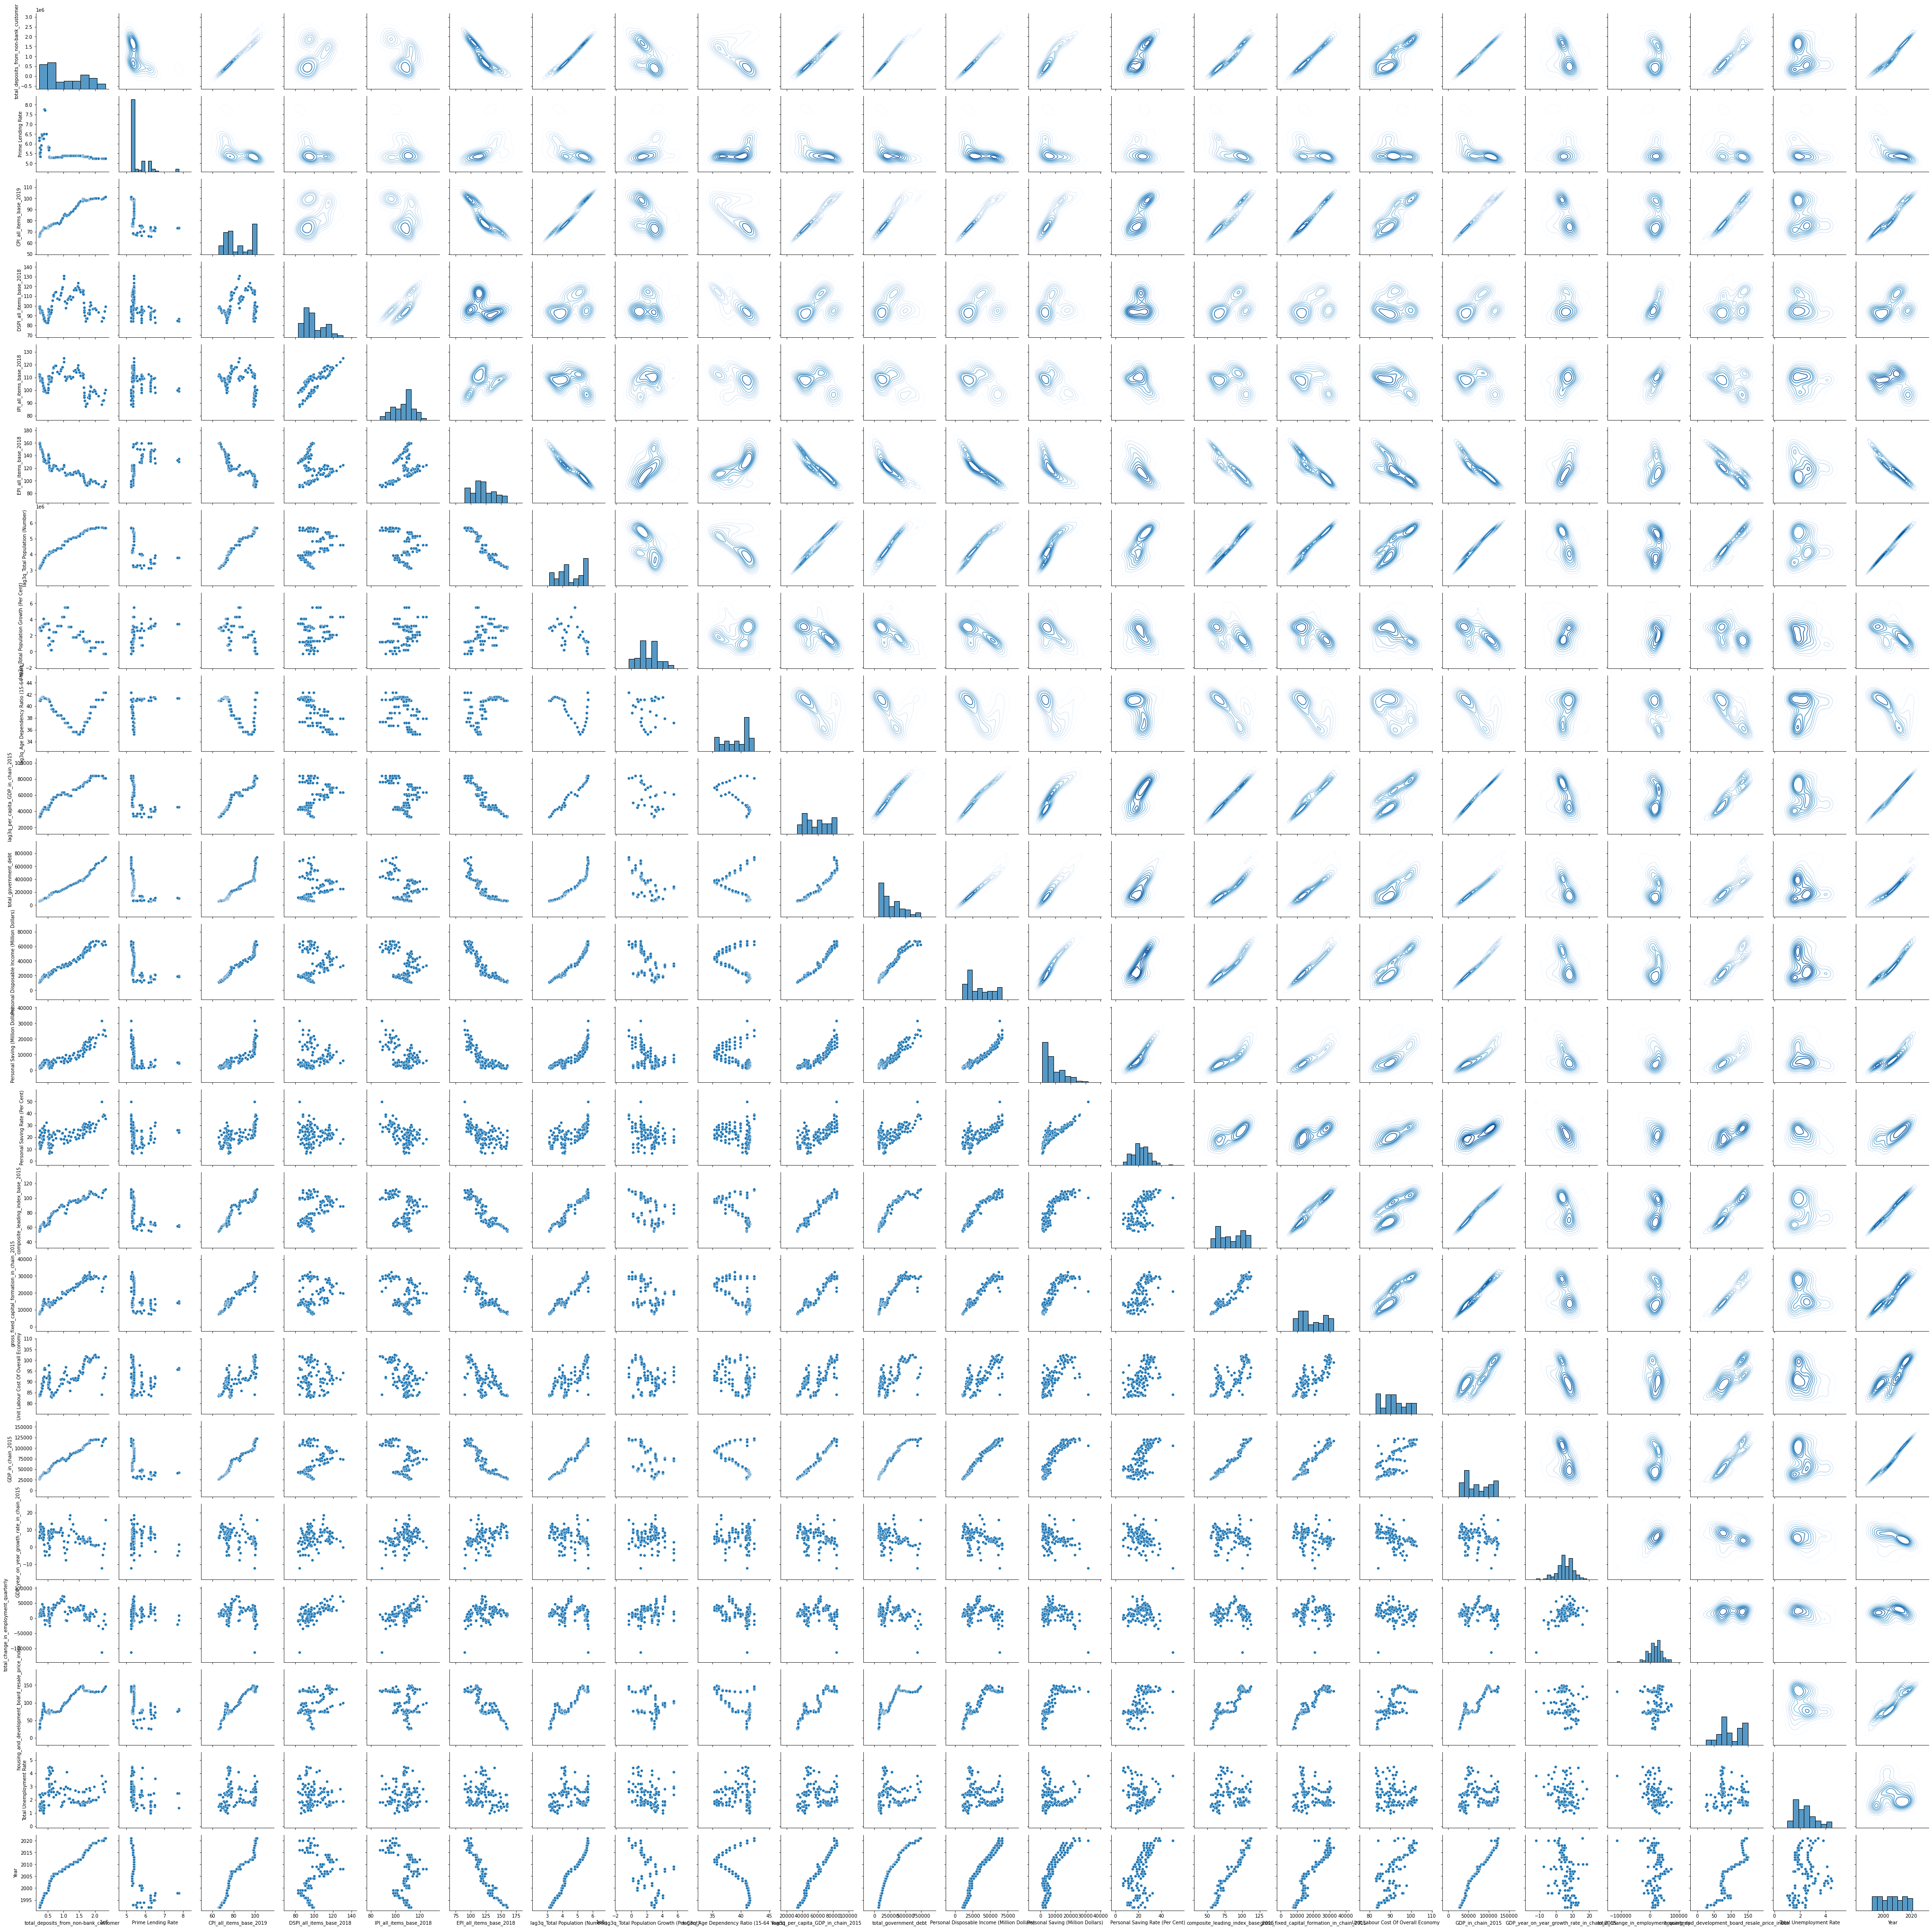

In [18]:
import seaborn as sns

temp_df = df.copy()
temp_df["Qrt"] = temp_df["Data Series"].apply(lambda s: s.split(" ")[1][0])

display(temp_df.head())

g = sns.PairGrid(temp_df)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot, cmap="Blues")
# g.add_legend()

In [19]:
g.savefig("./output/figures/grid_pair.png")

In [67]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# result = seasonal_decompose(SLR_df.iloc[:, :2])
# result.plot()

 - feature selection, consider F-regression: https://stats.stackexchange.com/questions/204141/difference-between-selecting-features-based-on-f-regression-and-based-on-r2

### 2.2.2 AR models  

- credit: https://pythondata.com/forecasting-time-series-autoregression/  


In [68]:
# total deposit

# f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(8, 10))

# plt.suptitle(Y_COL_NAME, fontsize=16)

# plot_acf(y_df[Y_COL_NAME], ax=ax1, lags=30, use_vlines=True)

# plot_pacf(y_df[Y_COL_NAME], ax=ax2, lags=30, method="ywm", use_vlines=True)
# plt.show()

In [69]:
# first difference of total deposits

# Y_DIFF_1 = Y_COL_NAME + "_diff_1"

# f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(8, 10))

# plt.suptitle(Y_DIFF_1, fontsize=16)

# plot_acf(y_df[Y_DIFF_1], ax=ax1, lags=30, use_vlines=True)

# plot_pacf(y_df[Y_DIFF_1], ax=ax2, lags=30, method="ywm", use_vlines=True)
# plt.show()

In [70]:
# from statsmodels.tsa.ar_model import AutoReg
# from sklearn.metrics import r2_score

In [71]:
# X = y_df[Y_DIFF_1].copy()

# X_N = X.shape[0]

# # print(X)
# # print(X_N)

# train_data = X.iloc[1 : X_N - 12]
# test_data = X.iloc[X_N - 12 :]

# # print(train_data)
# # print(test_data)

# # train the autoregression model
# model = AutoReg(train_data, lags=50)
# model_fitted = model.fit()

# # make predictions
# predictions = model_fitted.predict(
#     start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False
# )

# print(model_fitted.aic, model_fitted.hqic, model_fitted.bic)


# # create a comparison dataframe
# compare_df = pd.concat([y_df[Y_DIFF_1].tail(12), predictions], axis=1).rename(
#     columns={"stationary": "actual", 0: "predicted"}
# )

# # plot the two values
# compare_df.plot()

# print(y_df[Y_DIFF_1].tail(12))
# print(predictions)

# r2 = r2_score(y_df[Y_DIFF_1].tail(12), predictions)


# print(r2)

### 2.2.3 MA models